In [1]:
import pandas as pd
import pandas as pd
import torch
from datetime import datetime

from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding, EarlyStoppingCallback

from transformers import (
    AutoTokenizer,
    DataCollatorWithPadding,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    pipeline,
)






2024-07-18 18:06:09.051243: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-18 18:06:09.051343: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-18 18:06:09.318715: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


!pip install mlflow dagshub

In [2]:
import pandas as pd




df_train = pd.read_csv(r'/kaggle/input/sample-3000/train_df_2100_manual_final.csv')
df_val = pd.read_csv(r'/kaggle/input/sample-3000/validation_df_450_manual_final.csv')
df_test = pd.read_csv(r'/kaggle/input/sample-3000/test_df_450_manual_final.csv')



total_df = pd.concat([df_train, df_val, df_test], axis=0)
total_df.shape

df_train.rename(columns={'manual labeling': 'manual_labeling'}, inplace=True)
df_val.rename(columns={'manual labeling': 'manual_labeling'}, inplace=True)
df_test.rename(columns={'manual labeling': 'manual_labeling'}, inplace=True)
total_df.rename(columns={'manual labeling': 'manual_labeling'}, inplace=True)


df_train['manual_labeling_new'] = df_train['manual_labeling'].replace({-1: 0, 0: 1, 1: 2})
df_test['manual_labeling_new'] = df_test['manual_labeling'].replace({-1: 0, 0: 1, 1: 2})
df_val['manual_labeling_new'] = df_val['manual_labeling'].replace({-1: 0, 0: 1, 1: 2})

total_df['manual_labeling_new'] = total_df['manual_labeling'].replace({-1: 0, 0: 1, 1: 2})


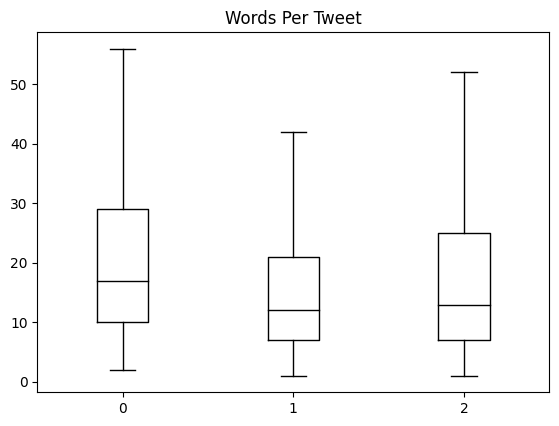

In [5]:
import matplotlib.pyplot as plt

total_df["Words Per Tweet"] = total_df["comment_processed_text"].str.split().apply(len)
total_df.boxplot("Words Per Tweet", by="manual_labeling_new", grid=False,
showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

from transformers import BertTokenizer, BertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased")

In [6]:
from transformers import AutoTokenizer
model_ckpt = "dccuchile/bert-base-spanish-wwm-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/310 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/486k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

In [7]:
from transformers import AutoModel
model_ckpt = "dccuchile/bert-base-spanish-wwm-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
from transformers import AutoModelForSequenceClassification
num_labels = 3
model = (AutoModelForSequenceClassification
.from_pretrained(model_ckpt, num_labels=num_labels)
.to(device))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',  # Padding
            truncation=True,       # Truncation
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)  # Ensure labels are tensors of type long
        }


In [10]:
# Extract texts and labels
train_texts = df_train['comment_processed_text'].tolist()
train_labels = df_train['manual_labeling_new'].tolist()
val_texts = df_val['comment_processed_text'].tolist()
val_labels = df_val['manual_labeling_new'].tolist()
test_texts = df_test['comment_processed_text'].tolist()
test_labels = df_test['manual_labeling_new'].tolist()

In [11]:
MAX_LEN = 512

# Create train, validation, and test datasets
train_dataset = SentimentDataset(train_texts, train_labels, tokenizer, MAX_LEN)
val_dataset = SentimentDataset(val_texts, val_labels, tokenizer, MAX_LEN)
test_dataset = SentimentDataset(test_texts, test_labels, tokenizer, MAX_LEN)

In [12]:
train_dataset[0]


{'text': 'uff lancha nueva',
 'input_ids': tensor([    4, 16397, 30977, 27666,  2035,     5,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
          

import os
# Ensure the output directory exists
output_dir = './results_beto'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Ensure the logging directory exists
logging_dir = './logs'
if not os.path.exists(logging_dir):
    os.makedirs(logging_dir)


model = BertForSequenceClassification.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased", num_labels=3)


pip install accelerate -U

In [ ]:
#pip install transformers[torch]

# Define custom metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }


In [15]:
# Define custom metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }


# Training the model

In [16]:
from huggingface_hub import notebook_login
notebook_login()



# Training Arguments
training_args = TrainingArguments(
    output_dir=output_dir,  # Use the output directory variable
    num_train_epochs=20,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir=logging_dir,
    report_to=[],
)

# Data Collator
data_collator = DataCollatorWithPadding(tokenizer)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,  # Add custom metrics
    data_collator=data_collator       # Add data collator
)

# Training Arguments
training_args = TrainingArguments(
    output_dir=output_dir,  # Use the output directory variable
    num_train_epochs=10,  # Increase number of epochs
    per_device_train_batch_size=16,  # Adjust batch size
    per_device_eval_batch_size=16,
    learning_rate=2e-5,  # Adjust learning rate
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir=logging_dir,
    eval_strategy="epoch",  # Evaluate at each epoch
    save_strategy="epoch",  # Save at each epoch
    save_total_limit=3,  # Only keep the last 3 checkpoints
    load_best_model_at_end=True,  # Load the best model found during training at the end
    metric_for_best_model="accuracy",  # Use accuracy to determine the best model
    greater_is_better=True,
    report_to=[],  # Disable all integrations
)

In [28]:
from transformers import Trainer, TrainingArguments


# Training Arguments
batch_size = 16
logging_steps = len(train_texts) // batch_size  #  to get the length of the list
model_name = f"{model_ckpt}-finetuned-political_elsalvadore"  


from transformers import Trainer, TrainingArguments

# batch_size = 64
# logging_steps = len(emotions_encoded["train"]) // batch_size
# model_name = f"{model_ckpt}-finetuned-emotion"
# training_args = TrainingArguments(output_dir=model_name,
# num_train_epochs=2,
# learning_rate=2e-5,
# per_device_train_batch_size=batch_size,
# per_device_eval_batch_size=batch_size,
# weight_decay=0.01,
# eval_strategy="epoch",
# disable_tqdm=False,
# logging_steps=logging_steps,
# push_to_hub=True,
# log_level="error")

# Training Arguments
training_args = TrainingArguments(
    output_dir = model_name,
    num_train_epochs=10,  # Increase number of epochs
    per_device_train_batch_size=batch_size,  # Adjust batch size
    per_device_eval_batch_size=batch_size,
    learning_rate=2e-5,  # Adjust learning rate
    weight_decay=0.01,
    eval_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=True,
    log_level="error"
)

# Data Collator
data_collator = DataCollatorWithPadding(tokenizer)
# Trainer with Early Stopping
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,  # Add custom metrics
    data_collator=data_collator,  
    tokenizer=tokenizer,# Add data collator
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]  # Add early stopping
)


In [29]:
# Data Collator
data_collator = DataCollatorWithPadding(tokenizer)
# Trainer with Early Stopping
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,  
    data_collator=data_collator,  
    tokenizer=tokenizer,
)


In [30]:
# Train the model
trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.636993,0.715556,0.716408,0.723712,0.715556
2,0.620000,0.633227,0.735556,0.734152,0.733271,0.735556
3,0.620000,0.704972,0.735556,0.738333,0.748825,0.735556
4,0.230600,0.885335,0.735556,0.733931,0.732962,0.735556
5,0.230600,1.029051,0.724444,0.725954,0.730030,0.724444
6,0.070400,1.188791,0.733333,0.736027,0.741631,0.733333
7,0.070400,1.335546,0.720000,0.724469,0.737613,0.720000
8,0.022500,1.380308,0.744444,0.746468,0.750013,0.744444
9,0.022500,1.482217,0.726667,0.730288,0.741489,0.726667
10,0.010800,1.444084,0.733333,0.735311,0.738641,0.733333


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

TrainOutput(global_step=660, training_loss=0.18942482223818927, metrics={'train_runtime': 1160.9639, 'train_samples_per_second': 18.088, 'train_steps_per_second': 0.568, 'total_flos': 5525381772288000.0, 'train_loss': 0.18942482223818927, 'epoch': 10.0})

In [31]:
trainer.push_to_hub(commit_message="Training completed_v1!")


events.out.tfevents.1721326726.6eb2fee7b431.34.1:   0%|          | 0.00/11.3k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/sagar213/bert-base-spanish-wwm-uncased-finetuned-political_elsalvadore/commit/a2d1dc76add2bda3d9efa3fbbea4c0521f4c561a', commit_message='Training completed_v1!', commit_description='', oid='a2d1dc76add2bda3d9efa3fbbea4c0521f4c561a', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
from torch.nn.functional import cross_entropy



def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")

    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

In [32]:
# # Evaluate the model on the validation set
# val_results = trainer.evaluate()
# print("Validation Results:", val_results)

# Evaluate the model on the test set
test_results = trainer.evaluate(eval_dataset=test_dataset)
print("Test Results:", test_results)



/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Test Results: {'eval_loss': 1.303358554840088, 'eval_accuracy': 0.78, 'eval_f1': 0.7796401936014123, 'eval_precision': 0.7794444444444445, 'eval_recall': 0.78, 'eval_runtime': 8.6935, 'eval_samples_per_second': 51.763, 'eval_steps_per_second': 1.725, 'epoch': 10.0}


In [33]:
trainer.push_to_hub(commit_message="Training completed_v1!")


events.out.tfevents.1721328104.6eb2fee7b431.34.2:   0%|          | 0.00/560 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/sagar213/bert-base-spanish-wwm-uncased-finetuned-political_elsalvadore/commit/b58a36b43f769c62187e21d5460603456abb1989', commit_message='Training completed_v1!', commit_description='', oid='b58a36b43f769c62187e21d5460603456abb1989', pr_url=None, pr_revision=None, pr_num=None)

In [60]:
val_results

{'eval_loss': 0.6352695226669312,
 'eval_accuracy': 0.7266666666666667,
 'eval_f1': 0.7290055924122579,
 'eval_precision': 0.7396993251501143,
 'eval_recall': 0.7266666666666667,
 'eval_runtime': 7.9827,
 'eval_samples_per_second': 56.372,
 'eval_steps_per_second': 1.879,
 'epoch': 7.0}

In [61]:
test_results

{'eval_loss': 0.605351984500885,
 'eval_accuracy': 0.7733333333333333,
 'eval_f1': 0.7731599172459577,
 'eval_precision': 0.7733569269335693,
 'eval_recall': 0.7733333333333333,
 'eval_runtime': 8.0612,
 'eval_samples_per_second': 55.823,
 'eval_steps_per_second': 1.861,
 'epoch': 7.0}

In [62]:
# # Generate and print the classification report for validation set
# preds_val = trainer.predict(val_dataset)
# labels_val = preds_val.label_ids
# predictions_val = preds_val.predictions.argmax(-1)
# print("\nClassification Report (Validation):")
# print(classification_report(labels_val, predictions_val, target_names=['negative', 'neutral', 'positive']))

# Generate and print the classification report for test set
preds_test = trainer.predict(test_dataset)
labels_test = preds_test.label_ids
predictions_test = preds_test.predictions.argmax(-1)
print("\nClassification Report (Test):")
print(classification_report(labels_test, predictions_test, target_names=['negative', 'neutral', 'positive']))

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '



Classification Report (Validation):
              precision    recall  f1-score   support

    negative       0.81      0.67      0.74       181
     neutral       0.59      0.70      0.64       138
    positive       0.79      0.82      0.81       131

    accuracy                           0.73       450
   macro avg       0.73      0.73      0.73       450
weighted avg       0.74      0.73      0.73       450



/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '



Classification Report (Test):
              precision    recall  f1-score   support

    negative       0.82      0.80      0.81       181
     neutral       0.69      0.69      0.69       138
    positive       0.80      0.83      0.81       131

    accuracy                           0.77       450
   macro avg       0.77      0.77      0.77       450
weighted avg       0.77      0.77      0.77       450



In [64]:
# Define the paths where you want to save the model and tokenizer
import os

model_save_path = './saved_model'
if not os.path.exists(model_save_path):
    os.makedirs(model_save_path)

tokenizer_save_path = './saved_tokenizer'
if not os.path.exists(tokenizer_save_path):
    os.makedirs(tokenizer_save_path)

    



In [65]:
# Save the model
model.save_pretrained(model_save_path)

# Save the tokenizer
tokenizer.save_pretrained(tokenizer_save_path)

('./saved_tokenizer/tokenizer_config.json',
 './saved_tokenizer/special_tokens_map.json',
 './saved_tokenizer/vocab.txt',
 './saved_tokenizer/added_tokens.json')

In [36]:
pip install datetime

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 766.4 kB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.8/247.8 kB 3.8 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [38]:
# Save the model and tokenizer with a unique name
import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_save_path = f'./saved_model_{timestamp}'
tokenizer_save_path = f'./saved_tokenizer_{timestamp}'

if not os.path.exists(model_save_path):
    os.makedirs(model_save_path)
if not os.path.exists(tokenizer_save_path):
    os.makedirs(tokenizer_save_path)

# Save the model
model.save_pretrained(model_save_path)

# Save the tokenizer
tokenizer.save_pretrained(tokenizer_save_path)

AttributeError: module 'datetime' has no attribute 'now'